In [1]:
import jax.numpy as jnp
import numpy as np
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time
import optax
from tqdm import tqdm
from functools import partial
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

from jax.config import config

config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)


In [2]:
import os
os.chdir('/Users/hudsonchen/research/fx_bayesian_quaduature/CBQ')
from utils import SIR_utils
from kernels import *

In [46]:
@jax.jit
def time_step(beta, gamma, population, St, It, Rt, dt, rng_key):
    dS = -beta * St * It * dt / population
    dI = (beta * St * It / population - gamma * It) * dt
    dR = gamma * It * dt
    St = St + dS
    It = It + dI
    Rt = Rt + dR
    return St, It, Rt


def generate_data(beta, gamma, T, dt, population, rng_key):
    """
    :param beta: float, infection rate
    :param gamma: float, recovery rate
    :param rng_key:
    :param T: Time length
    :return: array T*3, the first is number of Susceptible,
    the second is Infected, the third is Recoverdd
    """
    It, Rt = 50., 0.
    St = population - It - Rt
    
    S_list = []
    I_list = []
    R_list = []
    iter_ = int(T / dt)
    
    for i in range(iter_):
        S_list.append(St)
        I_list.append(It)
        R_list.append(Rt)
        St, It, Rt = time_step(beta, gamma, population, St, It, Rt, dt, rng_key)

    S_array = np.array(S_list)
    I_array = np.array(I_list)
    R_array = np.array(R_list)

    # # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(np.arange(iter_), S_array, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(np.arange(iter_), I_array, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(np.arange(iter_), R_array, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.title(f'Infection rate is {beta}')
    plt.show()

    D_real = {'S': S_array, 'I': I_array, 'R': R_array}
    pause = True
    return D_real


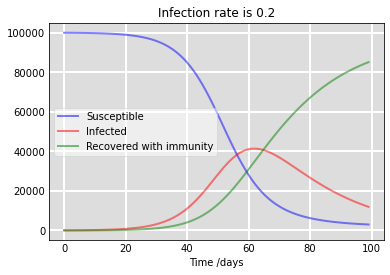

In [53]:
population = float(1e5)
beta, gamma = 0.20, 0.05
T = 100
dt = 1.
time_target = 100

seed = int(time.time())
rng_key = jax.random.PRNGKey(seed)


D = generate_data(beta, gamma, T, dt, population, rng_key)


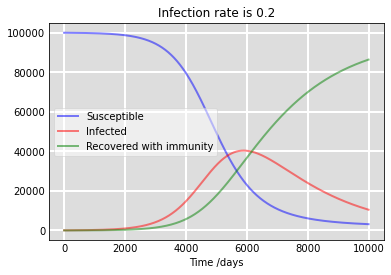

In [48]:
population = float(1e5)
beta, gamma = 0.20, 0.05
T = 100
dt = 0.01
time_target = 100

seed = int(time.time())
rng_key = jax.random.PRNGKey(seed)


D = generate_data(beta, gamma, T, dt, population, rng_key)


In [16]:
def stein_Matern(x, y, l, d_log_px, d_log_py):
    """
    :param x: N*D
    :param y: M*D
    :param l: scalar
    :param d_log_px: N*D
    :param d_log_py: M*D
    :return: N*M
    """
    N, D = x.shape
    M = y.shape[0]

    batch_kernel = tfp.math.psd_kernels.MaternThreeHalves(amplitude=1., length_scale=l)
    grad_x_K_fn = jax.grad(batch_kernel.apply, argnums=0)
    vec_grad_x_K_fn = jax.vmap(grad_x_K_fn, in_axes=(0, 0), out_axes=0)
    grad_y_K_fn = jax.grad(batch_kernel.apply, argnums=1)
    vec_grad_y_K_fn = jax.vmap(grad_y_K_fn, in_axes=(0, 0), out_axes=0)

    grad_xy_K_fn = jax.jacfwd(jax.jacrev(batch_kernel.apply, argnums=1), argnums=0)

    def diag_sum_grad_xy_K_fn(x, y):
        return jnp.diag(grad_xy_K_fn(x, y)).sum()

    vec_grad_xy_K_fn = jax.vmap(diag_sum_grad_xy_K_fn, in_axes=(0, 0), out_axes=0)

    x_dummy = jnp.stack([x] * N, axis=1).reshape(N * M, D)
    y_dummy = jnp.stack([y] * M, axis=0).reshape(N * M, D)

    K = batch_kernel.matrix(x, y)
    dx_K = vec_grad_x_K_fn(x_dummy, y_dummy).reshape(N, M, D)
    dy_K = vec_grad_y_K_fn(x_dummy, y_dummy).reshape(N, M, D)
    dxdy_K = vec_grad_xy_K_fn(x_dummy, y_dummy).reshape(N, M)

    part1 = d_log_px @ d_log_py.T * K
    part2 = (d_log_py[None, :] * dx_K).sum(-1)
    part3 = (d_log_px[:, None, :] * dy_K).sum(-1)
    part4 = dxdy_K
    
    print(part1)
    print("===========/n/n")
    print(part2)
    print("===========/n/n")
    print(part3)
    print("===========/n/n")
    print(part4)
    print("===========/n/n")
    return part1 + part2 + part3 + part4


In [17]:
def my_stein_Matern(x, y, l, d_log_px, d_log_py):
    """
    :param x: N*D
    :param y: M*D
    :param l: scalar
    :param d_log_px: N*D
    :param d_log_py: M*D
    :return: N*M
    """
    K = my_Matern(x, y, l)
    dx_K = dx_Matern(x, y, l)
    dy_K = dy_Matern(x, y, l)
    dxdy_K = dxdy_Matern(x, y, l)
    part1 = d_log_px @ d_log_py.T * K
    part2 = (d_log_py[None, :] * dx_K).sum(-1)
    part3 = (d_log_px[:, None, :] * dy_K).sum(-1)
    part4 = dxdy_K
    return part1 + part2 + part3 + part4

In [18]:
def log_posterior(beta, gamma, D_real, population, beta_lab, T, log_posterior_scale, rng_key):
    rate = 10.
    scale = 1. / rate

    log_prior_beta = jax.scipy.stats.gamma.logpdf(beta / scale, a=rate * beta_lab)
    S_real, I_real, _, delta_I_real, _ = D_real['S'], D_real['I'], D_real['R'], D_real['dI'], D_real['dR']
    
    P_sim = 1 - jnp.exp(-beta * (I_real / population))
    mean = S_real * P_sim 
    cov = S_real * P_sim * (1 - P_sim)
    log_likelihood = jax.scipy.stats.multivariate_normal.logpdf(delta_I_real, mean=mean, cov=jnp.diag(cov))
    return log_prior_beta + log_likelihood

def MCMC(rng_key, beta_lab, nsamples, init_params, log_prob):
    rng_key, _ = jax.random.split(rng_key)
    @jax.jit
    def run_chain(rng_key, state):
        num_burnin_steps = int(1e3)
        # kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        #     tfp.mcmc.HamiltonianMonteCarlo(
        #         target_log_prob_fn=log_prob,
        #         num_leapfrog_steps=3,
        #         step_size=1.0),
        #         num_adaptation_steps=int(num_burnin_steps * 0.8))

        kernel = tfp.mcmc.NoUTurnSampler(log_prob, 1e-2)
        samples = tfp.mcmc.sample_chain(num_results=nsamples,
                                        num_burnin_steps=num_burnin_steps,
                                        current_state=state,
                                        kernel=kernel,
                                        trace_fn=None,
                                        seed=rng_key)
        return samples

    states = run_chain(rng_key, init_params)
    # Debug code
    # rate = 10.0
    # scale = 1. / rate
    # interval = jnp.linspace(0, 1, 100)
    # interval_pdf = 1. / scale * jax.scipy.stats.gamma.pdf(interval / scale, a=rate * beta_lab)
    # plt.figure()
    # plt.plot(interval, interval_pdf)
    # plt.hist(np.array(states), bins=10, alpha=0.8, density=True)
    # plt.show()
    pause = True
    return states

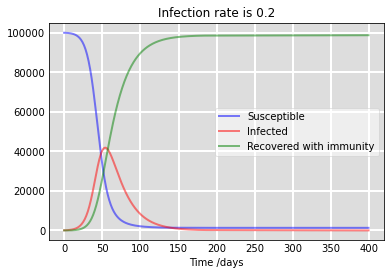

3377.0
43


In [104]:
population = float(1e5)
beta_real, gamma_real = 0.20, 0.05
beta_lab, gamma_lab = 0.45, 0.05
gamma = 0.05
rate = 10.0
scale = 1. / rate
T = 400
time_target = 100



seed = int(time.time())
rng_key = jax.random.PRNGKey(seed)

D1 = generate_data(beta_real, gamma, T, population, rng_key)

print(D1['dI'].max())
print(D1['dI'].argmax())


In [70]:
seed = int(time.time())
rng_key = jax.random.PRNGKey(seed)

D2, D_real_target = generate_data(beta_real, gamma, T, population, time_target, rng_key)
D_real_target = SIR_utils.convert_dict_to_jnp(D_real_target)

print(D2['I'].max())
print(D2['I'].argmax())


TypeError: generate_data() takes 5 positional arguments but 6 were given

In [22]:
D2['I']

array([5.0000e+01, 2.0000e+00, 7.6000e+01, 6.0000e+00, 1.1400e+02,
       1.0000e+01, 1.7100e+02, 2.0000e+01, 2.5200e+02, 4.0000e+01,
       3.7300e+02, 7.9000e+01, 5.5000e+02, 1.4500e+02, 8.0800e+02,
       2.5500e+02, 1.1850e+03, 4.3200e+02, 1.7350e+03, 7.1300e+02,
       2.5320e+03, 1.1540e+03, 3.6770e+03, 1.8320e+03, 5.3040e+03,
       2.8560e+03, 7.5790e+03, 4.3620e+03, 1.0682e+04, 6.5080e+03,
       1.4769e+04, 9.4350e+03, 1.9895e+04, 1.3210e+04, 2.5920e+04,
       1.7743e+04, 3.2440e+04, 2.2742e+04, 3.8834e+04, 2.7759e+04,
       4.4455e+04, 3.2342e+04, 4.8870e+04, 3.6192e+04, 5.1975e+04,
       3.9226e+04, 5.3930e+04, 4.1525e+04, 5.5015e+04, 4.3237e+04,
       5.5508e+04, 4.4517e+04, 5.5628e+04, 4.5490e+04, 5.5529e+04,
       4.6252e+04, 5.5310e+04, 4.6864e+04, 5.5034e+04, 4.7368e+04,
       5.4738e+04, 4.7794e+04, 5.4442e+04, 4.8160e+04, 5.4159e+04,
       4.8479e+04, 5.3892e+04, 4.8758e+04, 5.3641e+04, 4.9007e+04,
       5.3413e+04, 4.9228e+04, 5.3205e+04, 4.9427e+04, 5.3018e

In [463]:
N_MCMC = 1000
init_params = beta_lab
# This one is heuristic
log_posterior_scale = 100.
log_posterior_fn = partial(log_posterior, gamma=gamma_lab, D_real=D_real_target,
                           population=population, beta_lab=beta_lab, T=T,
                           log_posterior_scale=log_posterior_scale, rng_key=rng_key)

grad_log_posterior_fn = jax.grad(log_posterior_fn)

samples_post = MCMC(rng_key, beta_lab, N_MCMC, init_params, log_posterior_fn)
samples_post = jnp.unique(samples_post, axis=0)
rng_key, _ = jax.random.split(rng_key)
samples_post = jax.random.permutation(rng_key, samples_post)

In [464]:
samples_post[:10]

Array([0.48416378, 0.47569676, 0.48217276, 0.48495907, 0.49032113,
       0.48024609, 0.49385615, 0.48065572, 0.47653709, 0.48988868],      dtype=float64)

In [488]:
grad_log_posterior_fn(0.4)

Array(1292.78147948, dtype=float64, weak_type=True)

In [466]:
Ny = 100

beta_array = jnp.zeros([Ny, 1])
f_beta_array = jnp.zeros([Ny])
d_log_beta_array = jnp.zeros([Ny, 1])

for i in tqdm(range(Ny)):
    beta = samples_post[i]
    d_log_beta = grad_log_posterior_fn(beta)
    beta_array = beta_array.at[i, :].set(beta)
    d_log_beta_array = d_log_beta_array.at[i, :].set(d_log_beta)



100%|██████████| 100/100 [00:04<00:00, 24.02it/s]


In [467]:
beta

Array(0.50243678, dtype=float64)

In [489]:

l = 1.0

K = stein_Matern(beta_array, beta_array, 0.03, d_log_beta_array, d_log_beta_array)


[[  1025.54763864  -2055.65031112    268.86609147 ...  -2526.65180084
   -2244.68888076   5396.17830856]
 [ -2055.65031112   4941.3850795    -561.33565542 ...   6237.20801137
    5454.91672144  -8993.10106308]
 [   268.86609147   -561.33565542     71.35918621 ...   -693.13326746
    -614.10581518   1339.827167  ]
 ...
 [ -2526.65180084   6237.20801137   -693.13326746 ...   7929.18628603
    6904.66699836 -10801.00648592]
 [ -2244.68888076   5454.91672144   -614.10581518 ...   6904.66699836
    6028.68175449  -9728.82954496]
 [  5396.17830856  -8993.10106308   1339.827167   ... -10801.00648592
   -9728.82954496  55456.32340604]]
===========/n/n
[[   -0.         -1216.8350511     49.97542388 ... -1664.25792444
  -1389.65773099 -4994.44109334]
 [ -554.35156873     0.          -125.46756191 ...  -409.30588239
   -147.88535079 -4482.66838708]
 [ -189.45647891 -1044.07299847    -0.         ... -1494.19602118
  -1216.28604245 -4937.18945352]
 ...
 [ -598.52768346   323.11567378  -141.74841433

In [490]:
d_log_beta_array.T

Array([[ -32.02417272,   70.29498616,   -8.44743666,  -41.3606203 ,
        -103.12942818,   14.64678999, -142.7564157 ,    9.71348357,
          59.8958423 ,  -98.2227398 ,   -9.9058562 ,   63.14071677,
         112.99455462,  -97.81036237,  134.9350268 ,  -47.00055897,
         231.58912041,  114.25338421,  -39.03788214,   40.37210712,
        -112.29223725, -180.43630902, -137.22763697,  -75.57172309,
         168.95819928,   28.40472076, -245.68532732, -189.78958668,
         -84.56424393, -211.92470383,  153.28240566,   95.1674971 ,
          17.25038371,  114.99110972, -200.30252664,   27.98828526,
         -96.9753929 ,  116.11655085,  -56.00516065,  212.30190082,
         -22.24394755,  278.93450261, -237.14281932, -257.73140221,
         100.03427197,  -60.64160148, -126.51590885,  100.59765152,
        -101.44943247,  -95.33204382, -136.44338559, -126.33692435,
         -68.93265842,    0.8827674 ,   69.34944806,  103.7759428 ,
         239.91682373, -149.39484253,  163.13465

In [476]:
K[:5, :5]

Array([[ 1025.54763864, -2781.80333124,  2759.18671337,  4337.10174701,
         3620.22608477],
       [-2781.80333124,  4941.3850795 ,  -294.8956213 , -3725.00457867,
        -9158.07793574],
       [ 2759.18671337,  -294.8956213 ,    71.35918621,  2466.53454644,
          296.4427817 ],
       [ 4337.10174701, -3725.00457867,  2466.53454644,  1710.7009115 ,
         4977.34449531],
       [ 3620.22608477, -9158.07793574,   296.4427817 ,  4977.34449531,
        10635.67895729]], dtype=float64)

In [477]:
K

Array([[  1025.54763864,  -2781.80333124,   2759.18671337, ...,
         -3994.09206878,  -3264.98673801,   1017.09709368],
       [ -2781.80333124,   4941.3850795 ,   -294.8956213 , ...,
          8941.72216915,   8552.4243835 , -15200.99918328],
       [  2759.18671337,   -294.8956213 ,     71.35918621, ...,
         -1195.13030903,   -650.58987453,  -3596.08450206],
       ...,
       [ -3994.09206878,   8941.72216915,  -1195.13030903, ...,
          7929.18628603,   9867.30723354, -17195.06950567],
       [ -3264.98673801,   8552.4243835 ,   -650.58987453, ...,
          9867.30723354,   6028.68175449, -16014.45889307],
       [  1017.09709368, -15200.99918328,  -3596.08450206, ...,
        -17195.06950567, -16014.45889307,  55456.32340604]],      dtype=float64)

In [479]:
jnp.linalg.det(K[:10, :10])

Array(1.80600093e+34, dtype=float64)

In [356]:
batch_kernel = tfp.math.psd_kernels.MaternThreeHalves(amplitude=1., length_scale=l)

In [358]:
K = batch_kernel.matrix(y, y)

NameError: name 'y' is not defined